In [11]:
import time
import torch
import torch.nn as nn

from copy import deepcopy
from torch.distributions.dirichlet import Dirichlet
from torch.utils.data import DataLoader

import os
from utils import *

torch.set_printoptions(precision=3,
                       threshold=1000,
                       edgeitems=5,
                       linewidth=1000,
                       sci_mode=False)
t = time.localtime()
log_path = f'./log/{t.tm_year}-{t.tm_mon}-{t.tm_mday}/'
if not os.path.exists(log_path):
    os.makedirs(log_path)
log_path += f'{t.tm_hour}-{t.tm_min}-{t.tm_sec}.log'
log = get_logger(log_path)


'''1. basic parameters'''
# args = get_args()
n_client = 9
n_train_data = 1000
n_test_data = 200
local_epochs = 30
batch_size = 160
server_epochs = 1
alpha = 1.0
dataset = 'cifar10'
model_structure = 'resnet18'

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

all_client = range(n_client)
acc = {i: [] for i in all_client}
acc_server = []
setup_seed()

'''2. data preparation'''
train_set = CIFAR10(root='./data',
                         train=True,
                         download=True,
                         transform=torchvision.transforms.ToTensor())
test_set = CIFAR10(root='./data',
                        train=False,
                        transform=torchvision.transforms.ToTensor())
n_targets = 10
in_channel = 3
pro = Dirichlet(torch.full(size=(n_targets,),
                           fill_value=float(alpha))).sample([n_client])
train_set = split_non_iid(
    dataset=train_set,
    pro=pro,
    n_data=n_train_data,
    n_client=n_client,
)
test_set = split_non_iid(
    dataset=test_set,
    pro=pro,
    n_data=n_test_data,
    n_client=n_client,
)

Files already downloaded and verified


In [12]:
for key, dataset in train_set.items():
    targets = [data_[1] for data_ in dataset]
    for i in range(n_targets):
        print(len([target for target in targets if target == i]), end=' ')
    print()

375 59 15 7 31 51 24 265 40 133 
99 263 81 226 63 23 81 118 13 33 
39 58 7 29 258 40 126 398 16 29 
45 29 34 206 172 134 69 98 62 151 
11 105 20 40 65 42 67 92 182 376 
126 301 31 7 81 158 73 34 121 68 
61 63 63 189 178 147 132 40 67 60 
45 275 202 314 21 57 16 36 24 10 
269 60 75 40 212 23 31 77 137 76 


In [13]:
for key, dataset in test_set.items():
    targets = [data_[1] for data_ in dataset]
    for i in range(n_targets):
        print(len([target for target in targets if target == i]), end=' ')
    print()

75 12 3 1 6 10 5 53 8 27 
20 51 16 45 13 5 16 24 3 7 
8 12 1 6 52 8 25 79 3 6 
9 6 7 41 34 27 14 20 12 30 
2 21 4 8 13 8 13 18 36 77 
25 60 6 1 16 32 15 7 24 14 
12 13 13 38 36 29 26 8 13 12 
9 55 40 64 4 11 3 7 5 2 
55 12 15 8 42 5 6 15 27 15 


In [14]:
test_loader = {}
for i, dataset_ in test_set.items():
    test_loader[i] = DataLoader(dataset=dataset_,
                                batch_size=10,
                                pin_memory=True,
                                num_workers=8)
if model_structure == 'mlp':
    client_list = model_init(num_client=n_client,
                             model_structure='mlp',
                             num_target=n_targets,
                             in_channel=in_channel)
elif model_structure == 'resnet18':
    client_list = model_init(num_client=n_client,
                             model_structure='resnet18',
                             num_target=n_targets,
                             in_channel=in_channel)
elif model_structure == 'cnn1':
    client_list = model_init(num_client=n_client,
                             model_structure='cnn1',
                             num_target=n_targets,
                             in_channel=in_channel)
elif model_structure == 'cnn2':
    client_list = model_init(num_client=n_client,
                             model_structure='cnn2',
                             num_target=n_targets,
                             in_channel=in_channel)
elif model_structure == 'lenet5':
    client_list = model_init(num_client=n_client,
                             model_structure='lenet5',
                             num_target=n_targets,
                             in_channel=in_channel)
else:
    raise ValueError(f'No such model: {model_structure}')

train_loader = {}
for i, dataset_ in train_set.items():
    train_loader[i] = DataLoader(dataset=dataset_,
                                 batch_size=batch_size,
                                 num_workers=8,
                                 shuffle=True)


'''4. DDP: loss function initialization'''
CE_Loss = nn.CrossEntropyLoss().cuda()


'''5. model training and distillation'''
for server_epoch in range(server_epochs):
    # local train
    msg_local = '[server epoch {}, client {}, local train]'
    msg_test_local = 'local epoch {}, acc: {:.4f}'
    client_list_ = []
    lr = 1e-3 / (server_epoch + 1)
    for i, client in enumerate(client_list):
        print(msg_local.format(server_epoch + 1, i + 1))
        client_ = client.cuda()
        optimizer = torch.optim.Adam(params=client_.parameters(),
                                     lr=lr,
                                     weight_decay=1e-4)
        for local_epoch in range(local_epochs):
            for data_, target_ in train_loader[i]:
                optimizer.zero_grad()
                output_ = client_(data_.cuda())
                loss = CE_Loss(output_, target_.cuda())
                loss.backward()
                optimizer.step()

            # test
            model__ = client_
            acc[i].append(eval_model(model__, test_loader[i]))
            print(msg_test_local.format(local_epoch + 1, acc[i][-1]))
    break

[server epoch 1, client 1, local train]
local epoch 1, acc: 0.3750
local epoch 2, acc: 0.3750
local epoch 3, acc: 0.3000
local epoch 4, acc: 0.3450
local epoch 5, acc: 0.3500
local epoch 6, acc: 0.3800
local epoch 7, acc: 0.3800
local epoch 8, acc: 0.5450
local epoch 9, acc: 0.5500
local epoch 10, acc: 0.5400
local epoch 11, acc: 0.3400
local epoch 12, acc: 0.4700
local epoch 13, acc: 0.4550
local epoch 14, acc: 0.5850
local epoch 15, acc: 0.5050
local epoch 16, acc: 0.5200
local epoch 17, acc: 0.5350
local epoch 18, acc: 0.5100
local epoch 19, acc: 0.4400
local epoch 20, acc: 0.5500
local epoch 21, acc: 0.5100
local epoch 22, acc: 0.5100
local epoch 23, acc: 0.5700
local epoch 24, acc: 0.5500
local epoch 25, acc: 0.5650
local epoch 26, acc: 0.5650
local epoch 27, acc: 0.5550
local epoch 28, acc: 0.5500
local epoch 29, acc: 0.5850
local epoch 30, acc: 0.5900
[server epoch 1, client 2, local train]
local epoch 1, acc: 0.2250
local epoch 2, acc: 0.0800
local epoch 3, acc: 0.0750
local ep

In [2]:
import numpy as np
s = np.random.dirichlet((20, 10, 7), size=(2, 2))
print(s)

[[[0.57543875 0.21613701 0.20842424]
  [0.55323843 0.17804532 0.26871624]]

 [[0.54499191 0.32159236 0.13341573]
  [0.61687617 0.29255457 0.09056927]]]


In [89]:
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset

plt.style.use('default')
np.set_printoptions(precision=3,
                    threshold=1000,
                    edgeitems=1000,
                    linewidth=1000,
                    suppress=True)
n_clients = 3
dirichlet_alpha = 1.0
seed = 0  # 42
np.random.seed(seed)


def dirichlet_split_noniid(train_labels, alpha, n_clients):
    '''
    按照参数为alpha的Dirichlet分布将样本索引集合划分为n_clients个子集
    '''
    # 最大标签
    n_classes = train_labels.max()+1
    # (n_classes, n_clients) 类别标签分布矩阵X，记录每个类别划分到每个client去的比例
    label_distribution = np.random.dirichlet([alpha]*n_clients, n_classes)
    # print(label_distribution.shape)
    # print(label_distribution)
    # (n_classes, ...) 记录n_classes个类别对应的样本索引集合
    # print(np.argwhere(train_labels == 0))
    class_idcs = [np.argwhere(train_labels == y).flatten() for y in range(n_classes)]

    # 记录n_clients个client分别对应的样本索引集合
    client_idcs = [[] for _ in range(n_clients)]
    for k_idcs, fracs in zip(class_idcs, label_distribution):
        # k_idcs: 类别为k的样本索引集合
        # fracs: 类别为k的样本分配到n_clients个client的比例
        # print(len(k_idcs), len(fracs))
        # np.split按照比例fracs将类别为k的样本索引k_idcs划分为了n_clients个子集
        # i表示第i个client，idcs表示其对应的样本索引集合idcs
        # print(fracs)
        # print(np.cumsum(fracs))  # 累计和, 用于划分
        # print(np.cumsum(fracs)[:-1]*len(k_idcs))
        # print((np.cumsum(fracs)[:-1]*len(k_idcs)).astype(int))
        # 得到分割点
        split_point = np.split(k_idcs, (np.cumsum(fracs)[:-1]*len(k_idcs)).astype(int))
        # print([len(point) for point in split_point])
        for i, idcs in enumerate(split_point):
            # print(i, len(idcs), type(idcs))
            # 每个客户端加入对应的样本索引集合
            client_idcs[i] += [idcs]
        # break

    client_idx = [np.concatenate(idcs).tolist() for idcs in client_idcs]

    return client_idx


train_data = datasets.CIFAR10(
    root="./data/", download=True, train=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10(
    root="./data/", download=True, train=False, transform=transforms.ToTensor())
classes = train_data.classes
n_classes = len(classes)
labels = np.concatenate(
    [np.array(train_data.targets), np.array(test_data.targets)], axis=0)
dataset = ConcatDataset([train_data, test_data])

# 我们让每个client不同label的样本数量不同，以此做到Non-IID划分
client_idcs = dirichlet_split_noniid(
    labels, alpha=dirichlet_alpha, n_clients=n_clients)
dataset1 = [dataset[i] for i in client_idcs[0]]
# [print(len(i)) for i in client_idcs]
# print(dataset1[0])

Files already downloaded and verified
Files already downloaded and verified
15454
22383
22163
(tensor([[[0.7922, 0.7922, 0.8000,  ..., 0.8118, 0.8039, 0.7961],
         [0.8078, 0.8078, 0.8118,  ..., 0.8235, 0.8157, 0.8078],
         [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8314, 0.8235],
         ...,
         [0.8549, 0.8235, 0.7608,  ..., 0.9529, 0.9569, 0.9529],
         [0.8588, 0.8510, 0.8471,  ..., 0.9451, 0.9451, 0.9451],
         [0.8510, 0.8471, 0.8510,  ..., 0.9373, 0.9373, 0.9412]],

        [[0.8000, 0.8000, 0.8078,  ..., 0.8157, 0.8078, 0.8000],
         [0.8157, 0.8157, 0.8196,  ..., 0.8275, 0.8196, 0.8118],
         [0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
         ...,
         [0.8510, 0.8196, 0.7608,  ..., 0.9490, 0.9490, 0.9529],
         [0.8549, 0.8471, 0.8471,  ..., 0.9412, 0.9412, 0.9412],
         [0.8471, 0.8431, 0.8471,  ..., 0.9333, 0.9333, 0.9333]],

        [[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
         [0.7961, 0.7961, 0.

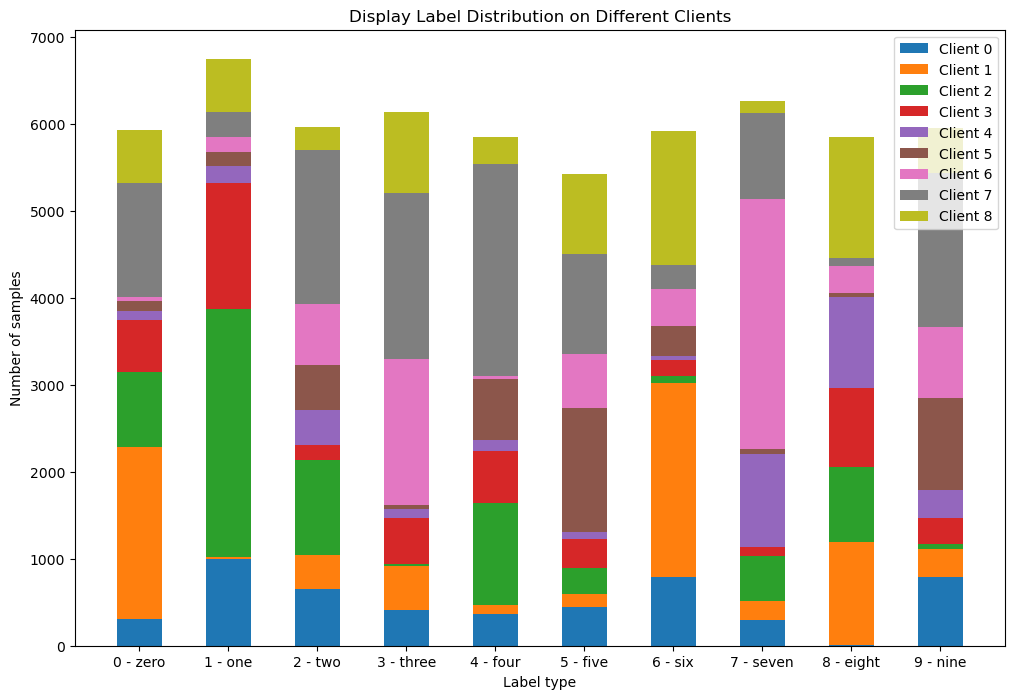

In [91]:
n_clients = 9
dirichlet_alpha = 1.0
seed = 42


if __name__ == "__main__":
    np.random.seed(seed)
    # train_data = datasets.EMNIST(
    #     root="./data/", split="byclass", download=True, train=True)
    # test_data = datasets.EMNIST(
    #     root="./data/", split="byclass", download=True, train=False)
    train_data = datasets.MNIST(
        root="./data/", download=True, train=True)
    test_data = datasets.MNIST(
        root="./data/", download=True, train=False)

    classes = train_data.classes
    n_classes = len(classes)

    # labels = np.concatenate(
    #     [np.array(train_data.targets), np.array(test_data.targets)], axis=0)
    # dataset = ConcatDataset([train_data, test_data])
    labels = np.array(train_data.targets)

    # 我们让每个client不同label的样本数量不同，以此做到Non-IID划分
    client_idcs = dirichlet_split_noniid(
        labels, alpha=dirichlet_alpha, n_clients=n_clients)

    # 展示不同label划分到不同client的情况
    plt.figure(figsize=(12, 8))
    plt.hist([labels[idc]for idc in client_idcs], stacked=True,
             bins=np.arange(min(labels)-0.5, max(labels) + 1.5, 1),
             label=["Client {}".format(i) for i in range(n_clients)],
             rwidth=0.5)
    plt.xticks(np.arange(n_classes), train_data.classes)
    plt.xlabel("Label type")
    plt.ylabel("Number of samples")
    plt.legend(loc="upper right")
    plt.title("Display Label Distribution on Different Clients")
    plt.show()

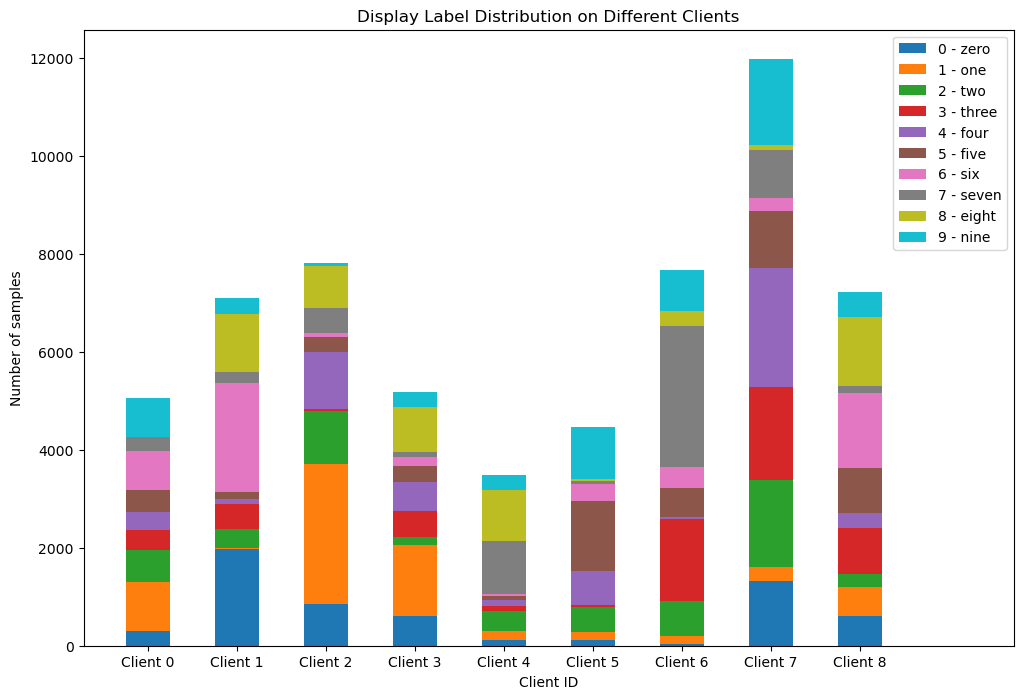

In [92]:
# 展示不同client上的label分布
plt.figure(figsize=(12, 8))
label_distribution = [[] for _ in range(n_classes)]
for c_id, idc in enumerate(client_idcs):
    for idx in idc:
        label_distribution[labels[idx]].append(c_id)

plt.hist(label_distribution, stacked=True,
            bins=np.arange(-0.5, n_clients + 1.5, 1),
            label=classes, rwidth=0.5)
plt.xticks(np.arange(n_clients), ["Client %d" %
                                    c_id for c_id in range(n_clients)])
plt.xlabel("Client ID")
plt.ylabel("Number of samples")
plt.legend()
plt.title("Display Label Distribution on Different Clients")
plt.show()

In [17]:
for i, j in enumerate(client_idcs):
    print(j)

[    1    21    34    37    51    56    63    68    69    75    81    88    95   108   114   118   119   121   156   169   192   206   209   210   216   229   232   234   246   249   260   283   293   296   303   320   326   359   399   427   429   435   440   451   453   458   462   464   473   489   519   524   526   527   542   577   582   596   603   612   633   639   656   662   666   667   668   669   689   702   709   712   733   743   745   776   781   787   790   818   825   849   859   860   869   872   889   903   927   943   949   952   957   965   979   984   997  1000  1015  1018  1028  1029  1040  1046  1049  1076  1078  1090  1093  1102  1107  1128  1137  1152  1168  1179  1195  1209  1268  1304  1310  1346  1349  1359  1363  1367  1368  1371  1372  1377  1386  1387  1403  1423  1443  1454  1471  1479  1489  1495  1501  1502  1512  1517  1530  1532  1571  1578  1590  1596  1600  1605  1606  1625  1626  1645  1664  1678  1682  1701  1709  1712  1723  1725  1729  1742
  1

In [104]:
from time import time, sleep

t0 = time()
print(t0)
sleep(1)
print(time() - t0)

1706095061.1342864
1.0004277229309082
